Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 992 images belonging to 2 classes.
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 198ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
2/2 ━━━━━━━━━━━━━

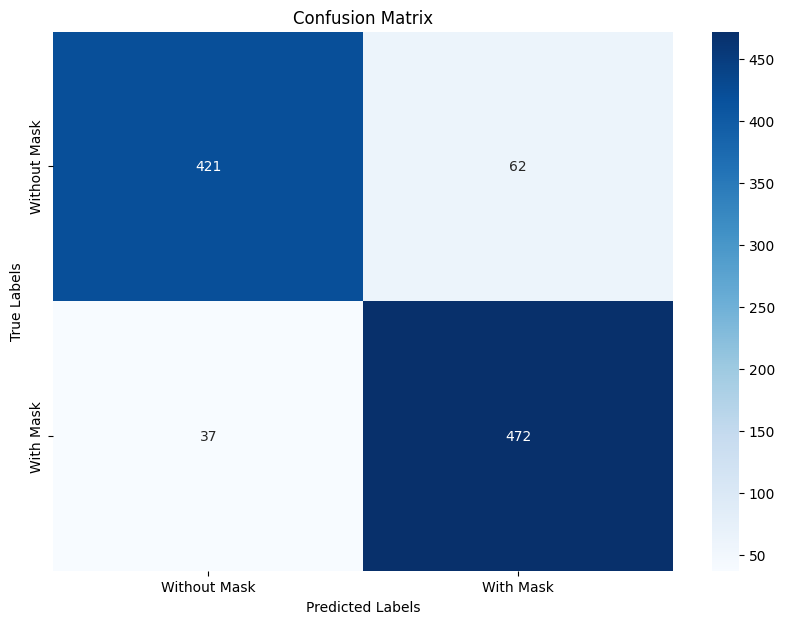

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

# Configure TensorFlow to avoid full memory usage
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

# Set paths to your data directories
train_dir = 'archive (2)\\Face Mask Dataset\\Train'
validation_dir = 'archive (2)\\Face Mask Dataset\\Validation'
test_dir = 'archive (2)\\Face Mask Dataset\\Test'

# Image dimensions
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 64

# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load train, validation, and test data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# Load MobileNetV2 model + higher level layers
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Extract features using MobileNetV2
def extract_features(generator):
    features = []
    labels = []
    for inputs_batch, labels_batch in generator:
        features_batch = base_model.predict(inputs_batch)
        features.append(features_batch)
        labels.append(labels_batch)
        if len(features) * BATCH_SIZE >= generator.samples:
            break
    return np.vstack(features), np.concatenate(labels)

train_features, train_labels = extract_features(train_generator)
validation_features, validation_labels = extract_features(validation_generator)
test_features, test_labels = extract_features(test_generator)

# Flatten extracted features
train_features = train_features.reshape((train_features.shape[0], -1))
validation_features = validation_features.reshape((validation_features.shape[0], -1))
test_features = test_features.reshape((test_features.shape[0], -1))

# Train a Decision Tree classifier
clf = DecisionTreeClassifier()
clf.fit(train_features, train_labels)

# Evaluate the model
validation_predictions = clf.predict(validation_features)
test_predictions = clf.predict(test_features)

# Print evaluation metrics
print("Validation accuracy: ", accuracy_score(validation_labels, validation_predictions))
print("Test accuracy: ", accuracy_score(test_labels, test_predictions))
print("Classification Report: \n", classification_report(test_labels, test_predictions))

# Confusion Matrix
conf_matrix = confusion_matrix(test_labels, test_predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Without Mask', 'With Mask'], yticklabels=['Without Mask', 'With Mask'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


